#Summary 

This notebook contains the classification models for capstone project "Quora Insincere Questions Classification". This classification task is one of Kaggle competitions such that the data set is been used for this capstone project.
Both traditional machine learning models and deep learning models have been devel0ped and the results been compared

Traditional Machine Learning:
* Bag-Of-Word (BOW) Logistic Regression (TF-IDF)
* Word2Vec Logistic Regression
* Pre-Trained Word2Vec Logistic Regression  (GoogleNews-vectors-negative300)
* Doc2Vec Logistic Regression 

Deep Learning :
* RNN with Embedding Layer
* RNN with Pre_trained Embedding layer
* Language Models (Flair)
* Language Models (Universal Sentence Encoder)
* Language Models (ULMFiT)


#0. Import Library, Define Functions and Constants

In [0]:
!pip install nltk
!pip install contractions
!pip install textsearch

     |████████████████████████████████| 317kB 4.0MB/s 
     |████████████████████████████████| 245kB 43.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81695 sha256=7c6902dcf81f31dba4298f6751d89b36daa048017a19d4d34949c41c6b6a21a8
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import nltk
import re
import contractions
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet, stopwords 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, zero_one_loss

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential, model_from_json
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Dropout, Activation
from tensorflow.python.keras import metrics
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def report(y, predicted):
    target_names = ['Sincere', 'Insincere']
        
    #classification_report 
    report = classification_report(y, predicted, target_names = target_names)
    print(report)
    
    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(matrix, annot = True, fmt = 'd')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return report, matrix
    
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
def plot_roc(y, predicted):
    #roc curve
    fpr, tpr, thresholds = roc_curve(y, predicted, pos_label = 1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color ='blue', lw = 1, label = 'ROC curve for sincere (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color ='black', lw = 1, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")
    plt.show()
    return roc_auc 
  
def store_matrix(name, y, pred):
    matrix_s = load(path +'matrix_project.sav')
    matrix_s[name] = {
        'Accuracy':accuracy_score(y, pred),
        'AUC':roc_auc_score(y, pred),
        'Precision (macro)':precision_score(y, pred, average='macro'),
        'Recall (macro)':recall_score(y, pred,average='macro'),
        'f1 (macro)':f1_score(y, pred, average='macro'),
        'misclassifications':zero_one_loss(y, pred)
    }
    dump(matrix_s, path+'matrix_project.sav')
    
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        #print("OOV, cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, docs):
    return np.vstack([word_averaging(wv, doc) for doc in docs])
  
def  word_doc2vec_list(model, docs):
    return np.vstack([model.infer_vector(doc.split()) for doc in docs])
  

def threeway_split(X, y):
    X_train, X_hold, y_train, y_hold  = train_test_split(X, y, 
                                                     train_size = 0.8, test_size = 0.2, 
                                                     random_state = 42, stratify = y)
    X_dev, X_test, y_dev, y_test  = train_test_split(X_hold, y_hold, 
                                                     train_size = 0.5, test_size = 0.5,  
                                                     random_state = 42, stratify = y_hold)

    print(len(X_train),len(X_dev), len(X_test))
    del X_hold, y_hold
    return X_train, X_dev, X_test, y_train, y_dev, y_test

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = path+"embeddings/glove.840B.300d/glove.840B.300d.txt"
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(num_words, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= num_words: continue
        embedding_vector = embeddings_index.get(word)
        #ALLmight
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix 
    
            
def load_fasttext(word_index):    
    EMBEDDING_FILE = path+"embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec"
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(num_words, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= num_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = path+'embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]

    nb_words = min(num_words, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= num_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix
  

In [0]:
num_words = 8000 
embedding_size = 300
max_tokens = 30
pad = 'post'
path = '/content/gdrive/My Drive/data/'
matrix_s ={}

In [0]:
#dump(matrix_s, path+'matrix_project.sav')
#matrix_s = load(path +'matrix_project.sav')


#1. Simple Raw Text Clean Up 

To align the comparison of results, although the different model can take slightly different texts (such as cap word, punctuation symbols, etc), the data go through unified text cleaning processes, which are:

* NFKD normalization
* Contraction Fix
* White space removal 
* Case unification
* Special character removal 

Both stop words and numerical numbers been retained, also no stemming nor lemmatization. During the prototyping stage, I have reported the stop word removal, numerical number removal, stemming and lemmatization does not change the result significantly. As the deep learning model, especial the language model (LM), prefers the sentence is un-attacked, I decided to make a compromise to use the same data for all models.

A balanced smaller data set also been sampled from the full data set for LM tuning. The full data set does not go through balancing attempt here as I already tested during prototyping which does not gain significant improvement.

In [0]:
train_data = pd.read_csv(path+'train.csv')
print('Training data set: ' + str(len(train_data)))

Training data set: 1306122


In [0]:
# simple text clean up
train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(contractions.fix).apply(remove_white_space).str.lower().apply(remove_special_character)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))

#remove empty text
train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
print(train_data.head())

dump(train_data, path+'train_data_project.sav')

Training data set: 1306116
   index                   qid  ... target  word_count
0      0  00002165364db923c7e6  ...      0          13
1      1  000032939017120e6e44  ...      0          16
2      2  0000412ca6e4628ce2cf  ...      0          10
3      3  000042bf85aa498cd78e  ...      0           9
4      4  0000455dfa3e01eae3af  ...      0          15

[5 rows x 5 columns]


['/content/gdrive/My Drive/data/train_data_project.sav']

In [0]:
train_data_s = pd.concat([train_data.loc[(train_data['target'] == 0) & (train_data['question_text'].str.len() > 10)].sample(n=90000, random_state=42),\
                          train_data.loc[(train_data['target'] == 1) & (train_data['question_text'].str.len() > 10)].sample(n=80000, random_state=42)], ignore_index=True)
train_data_s = train_data_s.sample(frac=1).reset_index(drop=True)
print('Training data set (small): ' + str(len(train_data_s)))
print(train_data_s.head())

dump(train_data, path+'train_data_s_project.sav')

Training data set (small): 170000
     index                   qid  ... target  word_count
0  1285631  fbf5431566f87792f7e2  ...      0           6
1  1172389  e5bf48f38fe2f8b189e4  ...      1          11
2  1092757  d6269961e626ea1f3781  ...      1           8
3   217786  2a9aa84cb68e29a649bc  ...      1          11
4    46176  090a7faac986862dc727  ...      0           6

[5 rows x 5 columns]


['/content/gdrive/My Drive/data/train_data_s_project.sav']

In [0]:
train_text = train_data['question_text']
train_target = train_data['target']
dump(train_text, path+'train_text_project.sav')
dump(train_target, path+'target_project.sav')

train_text_s = train_data_s['question_text']
train_target_s = train_data_s['target']
dump(train_text_s, path+'train_text_s_project.sav')
dump(train_target_s, path+'target_s_project.sav')

['/content/gdrive/My Drive/data/target_s_project.sav']

#2. Data Split: 80% (train) , 10% (dev) ,  10 %(test)

As the data set has 1.3M records, which is relatively big and falls into "having large data" category. Instead of withholding large potion for development and test, I take 10% for each and keep 80% of data for training 

A tokenized data also prepared here for RNN model which padded to the length of 30. Again, during prototyping, the distribution for length of words in each question has been plotted that 30 words covered 95%+ of the cases and the pre pad and post pad make a minimum difference.


In [0]:
X_train, X_dev, X_test, y_train, y_dev, y_test = threeway_split(train_text, train_target)
X_train_s, X_dev_s, X_test_s, y_train_s, y_dev_s, y_test_s = threeway_split(train_text_s, train_target_s)

1044892 130612 130612
136000 17000 17000


In [0]:
## used in 7 & 8 (RNN model)
tokenizer = Tokenizer(num_words=num_words, lower=False, char_level=False)
tokenizer.fit_on_texts(train_data['question_text'])

X_train_token  = tokenizer.texts_to_sequences(X_train)
X_dev_token  = tokenizer.texts_to_sequences(X_dev)
X_test_token  = tokenizer.texts_to_sequences(X_test)

X_train_token = pad_sequences(X_train_token, maxlen=max_tokens, padding=pad, truncating=pad).tolist()
X_dev_token = pad_sequences(X_dev_token, maxlen=max_tokens, padding=pad, truncating=pad).tolist()
X_test_token = pad_sequences(X_test_token, maxlen=max_tokens, padding=pad, truncating=pad).tolist()

dump(tokenizer, path+'tokenizer_project.sav')
dump(X_train, path+'X_train_project.sav')
dump(X_train_token, path+'X_train_token_project.sav')
dump(y_train, path+'y_train_project.sav')
dump(X_dev, path+'X_dev_project.sav')
dump(X_dev_token, path+'X_dev_token_project.sav')
dump(y_dev, path+'y_dev_project.sav')
dump(X_test, path+'X_test_project.sav')
dump(X_test_token, path+'X_test_token_project.sav')
dump(y_test, path+'y_test_project.sav')

['/content/gdrive/My Drive/data/y_test_project.sav']

#3. BOW (TF-IDF)  logistic regression 

Several traditional machine learning models, including Naive Bayes, Logistic Regression, Support Vector Machine, RandomForest, and  Gradient Boosting, have been tested. The parameters fine-tuning plays some effect but does not dramatically change the accuracy order for the models. Among these models, the Logistic Regression holds a top position and computation time.  Therefore, the Logistic Regression model has been selected to carry out the following comparison. 

TF-IDF is a typical Bag-Of-Word vectoring approach used in NLP modeling, the word's frequency counting has a similar result that will not be included in this notebook. The word size (max feature)  was select mainly due to the restriction on available memory resource.  


In [0]:
logreg = Pipeline([('vect', CountVectorizer(max_features=num_words, min_df=2, lowercase=False)),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False, max_df=1.0,
                                 max_features=8000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                  

              precision    recall  f1-score   support

     Sincere       0.99      0.89      0.94    122531
   Insincere       0.35      0.88      0.50      8081

    accuracy                           0.89    130612
   macro avg       0.67      0.88      0.72    130612
weighted avg       0.95      0.89      0.91    130612



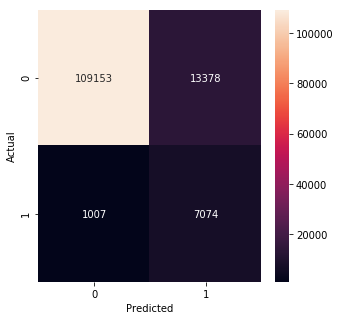

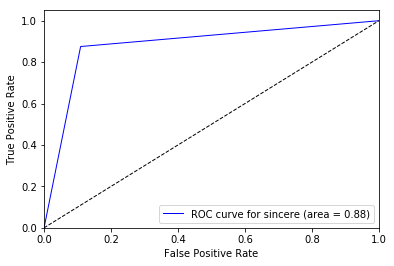

In [0]:
y_pred = logreg.predict(X_dev)
rep, mat = report(y_dev, y_pred)
roc_auc =plot_roc(y_dev, y_pred)
store_matrix("TF-IDF Logistic Regression (dev)", y_dev, y_pred)

y_pred = logreg.predict(X_train)
store_matrix("TF-IDF Logistic Regression (train)", y_train, y_pred)

del logreg

#4. Word2Vec Logistic Regression (Project Data)

Word2Vec, the word vector embedding is am important technic for NLP. The source of embedding can be from the project's data or existing pre-trained data. This section is using the project's data as the source for embedding. The selected dimension size is to align with the other word vector models to be compared with.   

As the word vector represents the dimensional vectors for each word, not the complete sentence. The completed dimensional vectors for the sentence needs to be aggregated in a consisted approach.  Therefore, the equal-weighted averaged vector is used for the word vector model, for both the pre-trained model and this one.



In [0]:
word2Vec_model = Word2Vec(train_text.str.split(), size=embedding_size, min_count=2, workers=4)
word2Vec_model.save(path+"embeddings/word2vec.model")
#word2Vec_model = Word2Vec.load(path+"embeddings/word2vec.model")

word2Vec_model = Word2Vec.load(path+"embeddings/word2vec.model")
quorawv = word2Vec_model.wv
quorawv.init_sims(replace=True)
del word2Vec_model

X_train_word_average = word_averaging_list(quorawv,X_train.str.split())
X_dev_word_average = word_averaging_list(quorawv,X_dev.str.split())

embeddinglogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])
embeddinglogreg.fit(X_train_word_average, y_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.99      0.87      0.92    122531
   Insincere       0.30      0.89      0.45      8081

    accuracy                           0.87    130612
   macro avg       0.65      0.88      0.69    130612
weighted avg       0.95      0.87      0.90    130612



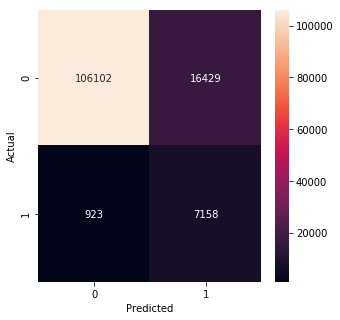

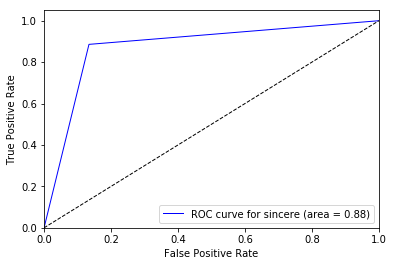

In [0]:
y_pred = embeddinglogreg.predict(X_dev_word_average)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)
store_matrix("Word2Vec Logistic Regression (dev)", y_dev, y_pred)

y_pred = embeddinglogreg.predict(X_train_word_average)
store_matrix("Word2Vec Logistic Regression (train)", y_train, y_pred)
del embeddinglogreg

#5. Pre-Trained word2Vec Logistic Regression

There are four pre-trained words vector models, including:

* glove.840B.300dm
* GoogleNews-vectors-negative300
* paragram_300_sl999
* wiki-news-300d-1

A uniformed approach, load the word vector matrix and retrieve the averaged dimensional vectors for each sentence has been applied. 

In [0]:
googlewv = KeyedVectors.load_word2vec_format(path+"embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)
googlewv.init_sims(replace=True)

X_train_word_average = word_averaging_list(googlewv,X_train.str.split())
X_dev_word_average = word_averaging_list(googlewv,X_dev.str.split())

embeddinglogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])
embeddinglogreg.fit(X_train_word_average, y_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.99      0.87      0.92    122531
   Insincere       0.30      0.88      0.45      8081

    accuracy                           0.87    130612
   macro avg       0.65      0.87      0.69    130612
weighted avg       0.95      0.87      0.89    130612



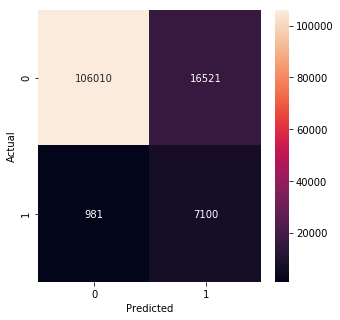

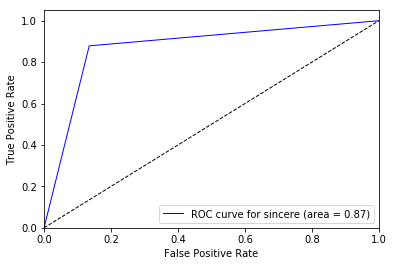

In [0]:
y_pred = embeddinglogreg.predict(X_dev_word_average)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)
store_matrix("Pre-Trained GoogleNew Logistic Regression (dev)", y_dev, y_pred)

y_pred = embeddinglogreg.predict(X_train_word_average)
store_matrix("Pre-Trained GoogleNew Logistic Regression (train)", y_train, y_pred)
del embeddinglogreg, googlewv

In [0]:
glove2word2vec(path+"embeddings/glove.840B.300d/glove.840B.300d.txt", path+"embeddings/glove.840B.300d/temp.txt")
glovewv = KeyedVectors.load_word2vec_format(path+"embeddings/glove.840B.300d/temp.txt", binary=False)
glovewv.init_sims(replace=True)

X_train_word_average = word_averaging_list(glovewv,X_train.str.split())
X_dev_word_average = word_averaging_list(glovewv,X_dev.str.split())

embeddinglogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])
embeddinglogreg.fit(X_train_word_average, y_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
W0819 20:59:25.910999 140268556015488 utils_any2vec.py:183] duplicate word '����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������' in /content/gdrive/My Drive/data/embeddings/glove.840B.300d/temp.txt, ignoring all but first
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be remove

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.99      0.87      0.93    122531
   Insincere       0.31      0.88      0.46      8081

    accuracy                           0.87    130612
   macro avg       0.65      0.88      0.69    130612
weighted avg       0.95      0.87      0.90    130612



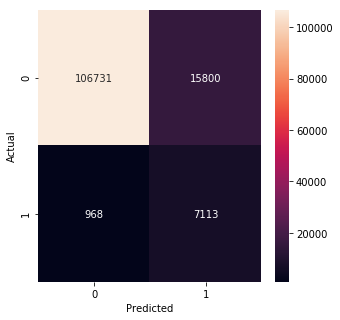

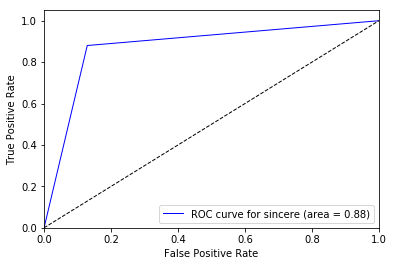

In [0]:
y_pred = embeddinglogreg.predict(X_dev_word_average)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)
store_matrix("Pre-Trained Glove Logistic Regression (dev)", y_dev, y_pred)

y_pred = embeddinglogreg.predict(X_train_word_average)
store_matrix("Pre-Trained Glove Logistic Regression (train)", y_train, y_pred)
del embeddinglogreg, glovewv

In [0]:
glove2word2vec(path+"embeddings/paragram_300_sl999/paragram_300_sl999.txt", path+"embeddings/paragram_300_sl999/temp.txt")
paragramwv = KeyedVectors.load_word2vec_format(path+"embeddings/paragram_300_sl999/temp.txt", encoding='ISO-8859-1', unicode_errors='ignore', binary=False)
paragramwv.init_sims(replace=True)

X_train_word_average = word_averaging_list(paragramwv,X_train.str.split())
X_dev_word_average = word_averaging_list(paragramwv,X_dev.str.split())

embeddinglogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])
embeddinglogreg.fit(X_train_word_average, y_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.99      0.86      0.92    122531
   Insincere       0.29      0.87      0.44      8081

    accuracy                           0.86    130612
   macro avg       0.64      0.86      0.68    130612
weighted avg       0.95      0.86      0.89    130612



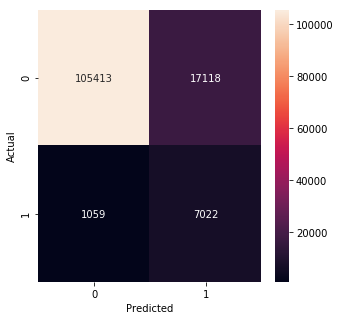

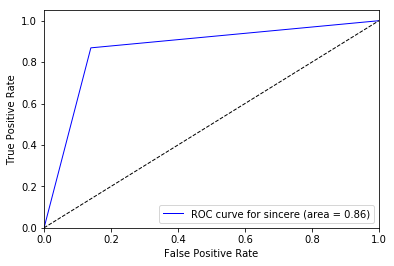

In [0]:
y_pred = embeddinglogreg.predict(X_dev_word_average)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)
store_matrix("Pre-Trained Paragram Logistic Regression (dev)", y_dev, y_pred)

y_pred = embeddinglogreg.predict(X_train_word_average)
store_matrix("Pre-Trained Paragram Logistic Regression (train)", y_train, y_pred)
del embeddinglogreg, paragramwv

In [0]:
wikiwv = KeyedVectors.load_word2vec_format(path+"embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec", binary=False)
wikiwv.init_sims(replace=True)

X_train_word_average = word_averaging_list(wikiwv,X_train.str.split())
X_dev_word_average = word_averaging_list(wikiwv,X_dev.str.split())

embeddinglogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])

embeddinglogreg.fit(X_train_word_average, y_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.99      0.87      0.92    122531
   Insincere       0.30      0.88      0.45      8081

    accuracy                           0.87    130612
   macro avg       0.65      0.87      0.69    130612
weighted avg       0.95      0.87      0.90    130612



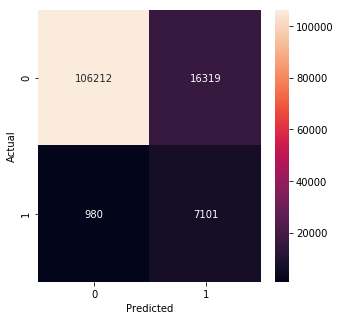

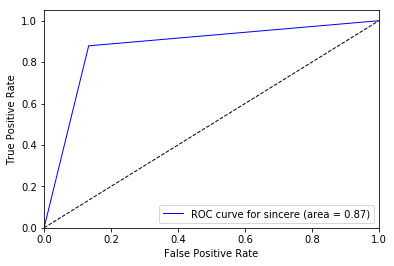

In [0]:
y_pred = embeddinglogreg.predict(X_dev_word_average)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)
store_matrix("Pre-Trained Wiki Logistic Regression (dev)", y_dev, y_pred)

y_pred = embeddinglogreg.predict(X_train_word_average)
store_matrix("Pre-Trained Wiki Logistic Regression (train)", y_train, y_pred)
del embeddinglogreg, wikiwv

#6. Doc2Vec Logistic Regression (Project Data)

Doc2Vec is a variation/enhancement of Word2Vec model. Instead of learning the dimensional vector for each word, it includes a unique id for the training document to better represents the intended training.  As there are not many pre-trained dov2vec models, the project's data is used to create a model here.  Both the word size and dimension size been applied to maintain comparability (also not to crash the runtime session).

In [0]:
documents = [TaggedDocument(doc.split(), [i]) for i, doc in X_train.items()]

doc2vec_model = Doc2Vec(documents, max_vocab_size=num_words, dm=1,\
                        alpha=0.065, min_alpha=0.00025, negative=5,\
                        min_count=2, vector_size=embedding_size, window=5, workers=4)


fname = get_tmpfile(path+"doc2vec_model")
doc2vec_model.save(fname)
doc2vec_model = Doc2Vec.load(fname)

X_train_doc2vec = word_doc2vec_list(doc2vec_model,X_train)
X_dev_doc2vec = word_doc2vec_list(doc2vec_model,X_dev)
doclogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])
doclogreg.fit(X_train_doc2vec, y_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.98      0.82      0.89    122531
   Insincere       0.21      0.73      0.33      8081

    accuracy                           0.81    130612
   macro avg       0.59      0.78      0.61    130612
weighted avg       0.93      0.81      0.86    130612



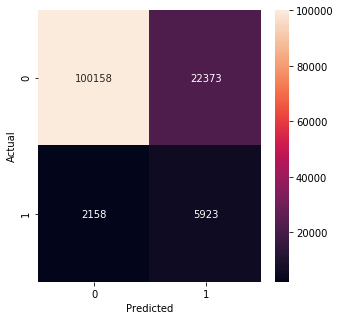

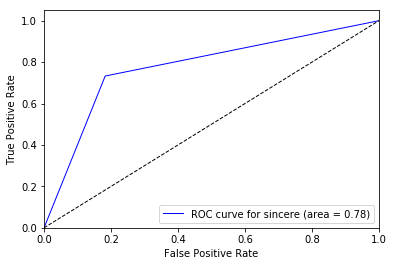

In [0]:
y_pred = doclogreg.predict(X_dev_doc2vec)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)
store_matrix("Doc2Vec (PV-DM) Logistic Regression (dev)", y_dev, y_pred)


y_pred = doclogreg.predict(X_train_doc2vec)
store_matrix("Doc2Vec (PV-DM) Logistic Regression (train)", y_train, y_pred)
del doclogreg, doc2vec_model

In [0]:
doc2vec_model = Doc2Vec(documents, max_vocab_size=num_words, dm=0,\
                        alpha=0.065, min_alpha=0.00025, negative=5,\
                        min_count=2, vector_size=embedding_size, window=5, workers=4)
fname = get_tmpfile(path+"doc2vec_model")
doc2vec_model.save(fname)
doc2vec_model = Doc2Vec.load(fname)
X_train_doc2vec = word_doc2vec_list(doc2vec_model,X_train)
X_dev_doc2vec = word_doc2vec_list(doc2vec_model,X_dev)

doclogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])
doclogreg.fit(X_train_doc2vec, y_train)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.98      0.81      0.89    122531
   Insincere       0.22      0.78      0.34      8081

    accuracy                           0.81    130612
   macro avg       0.60      0.80      0.62    130612
weighted avg       0.94      0.81      0.86    130612



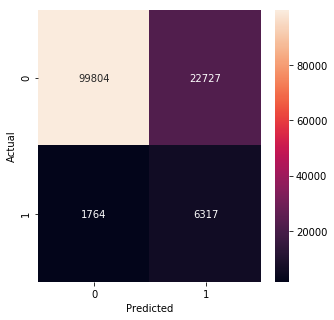

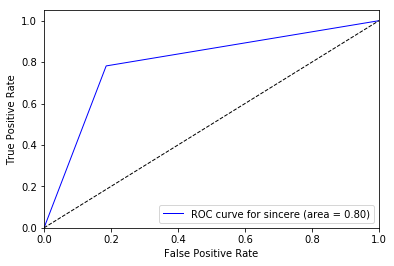

In [0]:
y_pred = doclogreg.predict(X_dev_doc2vec)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)
store_matrix("Doc2Vec (PV-DBOW) Logistic Regression (dev)", y_dev, y_pred)

y_pred = doclogreg.predict(X_train_doc2vec)
store_matrix("Doc2Vec (PV-DBOW) Logistic Regression (train)", y_train, y_pred)
del doclogreg, doc2vec_model

#7.  RNN With Embedding Layer 

Deep Learning / Artificial Neural Network represents a new era for NLP. The key for the deep learning including data input (the raw numerical data o embedded vector) and the architecture of the network. 

Again, during prototyping, RNN, CNN & DNN have been tested and all obtained good results at a similar level.  Not to overwhelm by the different architectural design, an RNN been applied for both project data embedding and pre-trained embedding.  

The number of layers and the number of nodes in each layer does not present special reason but for demonstration only.  no optimization has been performed for this type of model. 

In [0]:
X_train_token = load(path +'X_train_token_project.sav')
X_dev_token = load(path +'X_dev_token_project.sav')
y_train = load(path +'y_train_project.sav')
y_dev = load(path +'y_dev_project.sav')

model = Sequential()
optimizer = Adam(lr=1e-3)
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, dropout=0.5, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])
model.summary()

W0820 02:22:47.782673 140651346208640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 02:22:47.818003 140651346208640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 02:22:49.040132 140651346208640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 30, 300)           2400000   
_________________________________________________________________
gru (GRU)                    (None, 30, 32)            31968     
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 16)            2352      
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 8)             600       
_________________________________________________________________
gru_3 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 2,435,081
Trainable params: 2,435,081
Non-trainable params: 0
______________________________________________

In [0]:
history = model.fit(np.array(X_train_token), y_train, validation_data=(np.array(X_dev_token),y_dev), epochs=5, batch_size=500)

Train on 1044892 samples, validate on 130612 samples
Epoch 1/5
1044892/1044892 [==============================] - 527s 504us/sample - loss: 0.1538 - auc: 0.8987 - acc: 0.9503 - val_loss: 0.1190 - val_auc: 0.9426 - val_acc: 0.9543
Epoch 2/5
1044892/1044892 [==============================] - 525s 503us/sample - loss: 0.1142 - auc: 0.9473 - acc: 0.9559 - val_loss: 0.1157 - val_auc: 0.9492 - val_acc: 0.9548
Epoch 3/5
1044892/1044892 [==============================] - 524s 502us/sample - loss: 0.1072 - auc: 0.9553 - acc: 0.9583 - val_loss: 0.1149 - val_auc: 0.9483 - val_acc: 0.9555
Epoch 4/5
1044892/1044892 [==============================] - 524s 502us/sample - loss: 0.1011 - auc: 0.9606 - acc: 0.9609 - val_loss: 0.1164 - val_auc: 0.9459 - val_acc: 0.9551
Epoch 5/5
1044892/1044892 [==============================] - 525s 502us/sample - loss: 0.0949 - auc: 0.9652 - acc: 0.9635 - val_loss: 0.1195 - val_auc: 0.9420 - val_acc: 0.9543


              precision    recall  f1-score   support

     Sincere       0.97      0.98      0.98    122531
   Insincere       0.66      0.55      0.60      8081

    accuracy                           0.95    130612
   macro avg       0.81      0.77      0.79    130612
weighted avg       0.95      0.95      0.95    130612



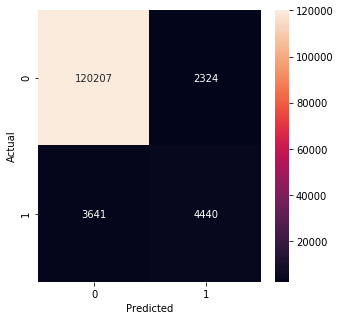

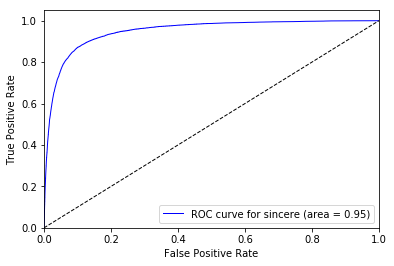

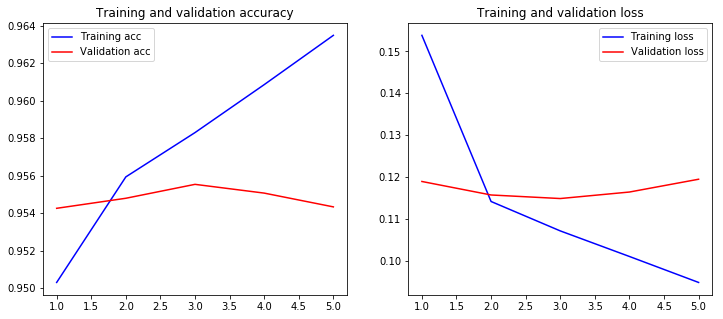

In [0]:
predicted = model.predict(np.array(X_dev_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
report(y_dev, cls_pred)
plot_roc(y_dev, predicted)
plot_history(history)
store_matrix("RNN (dev)", y_dev, cls_pred)


predicted = model.predict(np.array(X_train_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
store_matrix("RNN (train)", y_train, cls_pred)
del model

#8. RNN With  Pre-Trained Vector  

Similar to the word vector model presented earlier, the word vector embedding layer can switch among different existing pre-trained model. some pre-trained models bee applied here.


In all the models, the word embedding layer is not trainable.  To fine-tune the model, the embedding layer can be reset to trainable to adjust the vector according to the application data.  Ideally, it should achieve a better score as the word vector can adept the domain knowledge within the training data. The weight unfreeze was not performed due to a large number of comparable models already existing in this notebook.   

In [0]:
glove_embeddings = load_glove(tokenizer.word_index)    
model = Sequential()
optimizer = Adam(lr=1e-3)
model.add(Embedding(weights=[glove_embeddings], trainable=False, input_dim=num_words, output_dim=embedding_size, input_length=max_tokens))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, dropout=0.5, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           2400000   
_________________________________________________________________
gru_4 (GRU)                  (None, 30, 32)            31968     
_________________________________________________________________
gru_5 (GRU)                  (None, 30, 16)            2352      
_________________________________________________________________
gru_6 (GRU)                  (None, 30, 8)             600       
_________________________________________________________________
gru_7 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 2,435,081
Trainable params: 35,081
Non-trainable params: 2,400,000
_______________________________________

In [0]:
history = model.fit(np.array(X_train_token), y_train, validation_data=(np.array(X_dev_token),y_dev), epochs=4, batch_size=500)


Train on 1044892 samples, validate on 130612 samples
Epoch 1/4
1044892/1044892 [==============================] - 523s 501us/sample - loss: 0.1417 - auc_2: 0.9133 - acc: 0.9490 - val_loss: 0.1207 - val_auc_2: 0.9434 - val_acc: 0.9537
Epoch 2/4
1044892/1044892 [==============================] - 520s 498us/sample - loss: 0.1171 - auc_2: 0.9454 - acc: 0.9548 - val_loss: 0.1166 - val_auc_2: 0.9467 - val_acc: 0.9549
Epoch 3/4
1044892/1044892 [==============================] - 524s 502us/sample - loss: 0.1128 - auc_2: 0.9495 - acc: 0.9564 - val_loss: 0.1118 - val_auc_2: 0.9513 - val_acc: 0.9569
Epoch 4/4
1044892/1044892 [==============================] - 519s 497us/sample - loss: 0.1100 - auc_2: 0.9528 - acc: 0.9572 - val_loss: 0.1114 - val_auc_2: 0.9513 - val_acc: 0.9570


              precision    recall  f1-score   support

     Sincere       0.97      0.99      0.98    122531
   Insincere       0.71      0.51      0.59      8081

    accuracy                           0.96    130612
   macro avg       0.84      0.75      0.79    130612
weighted avg       0.95      0.96      0.95    130612



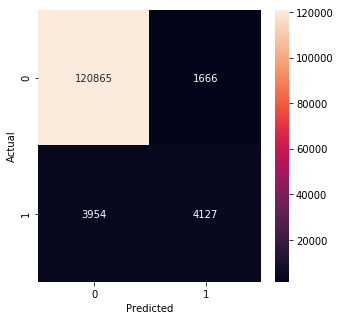

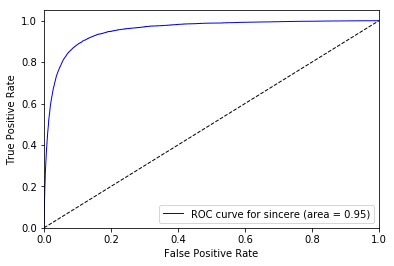

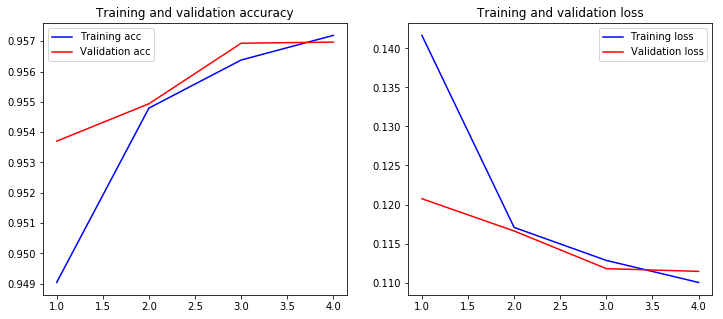

In [0]:
predicted = model.predict(np.array(X_dev_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
report(y_dev, cls_pred)
plot_roc(y_dev, predicted)
plot_history(history)
store_matrix("Glove RNN (dev)", y_dev, cls_pred)

predicted = model.predict(np.array(X_train_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
store_matrix("Glove RNN (train)", y_train, cls_pred)
del model, glove_embeddings

In [0]:
paragram_embeddings = load_para(tokenizer.word_index) 
model = Sequential()
optimizer = Adam(lr=1e-3)
model.add(Embedding(weights=[paragram_embeddings], trainable=False, input_dim=num_words, output_dim=embedding_size, input_length=max_tokens))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, dropout=0.5, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           2400000   
_________________________________________________________________
gru_8 (GRU)                  (None, 30, 32)            31968     
_________________________________________________________________
gru_9 (GRU)                  (None, 30, 16)            2352      
_________________________________________________________________
gru_10 (GRU)                 (None, 30, 8)             600       
_________________________________________________________________
gru_11 (GRU)                 (None, 4)                 156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 2,435,081
Trainable params: 35,081
Non-trainable params: 2,400,000
_______________________________________

In [0]:
history = model.fit(np.array(X_train_token), y_train, validation_data=(np.array(X_dev_token),y_dev), epochs=4, batch_size=500)


Train on 1044892 samples, validate on 130612 samples
Epoch 1/4
1044892/1044892 [==============================] - 527s 504us/sample - loss: 0.1464 - auc_4: 0.9048 - acc: 0.9485 - val_loss: 0.1210 - val_auc_4: 0.9391 - val_acc: 0.9530
Epoch 2/4
1044892/1044892 [==============================] - 525s 502us/sample - loss: 0.1185 - auc_4: 0.9436 - acc: 0.9547 - val_loss: 0.1157 - val_auc_4: 0.9464 - val_acc: 0.9558
Epoch 3/4
1044892/1044892 [==============================] - 523s 501us/sample - loss: 0.1139 - auc_4: 0.9488 - acc: 0.9562 - val_loss: 0.1134 - val_auc_4: 0.9495 - val_acc: 0.9563
Epoch 4/4
1044892/1044892 [==============================] - 524s 501us/sample - loss: 0.1110 - auc_4: 0.9515 - acc: 0.9571 - val_loss: 0.1126 - val_auc_4: 0.9505 - val_acc: 0.9565


              precision    recall  f1-score   support

     Sincere       0.97      0.98      0.98    122531
   Insincere       0.68      0.55      0.61      8081

    accuracy                           0.96    130612
   macro avg       0.83      0.77      0.79    130612
weighted avg       0.95      0.96      0.95    130612



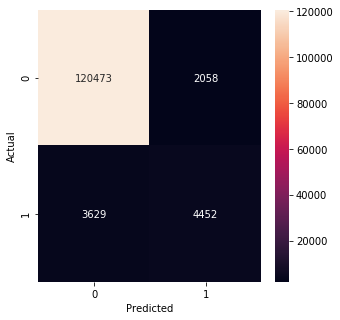

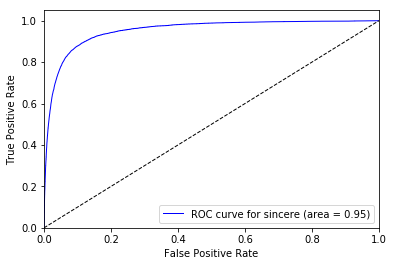

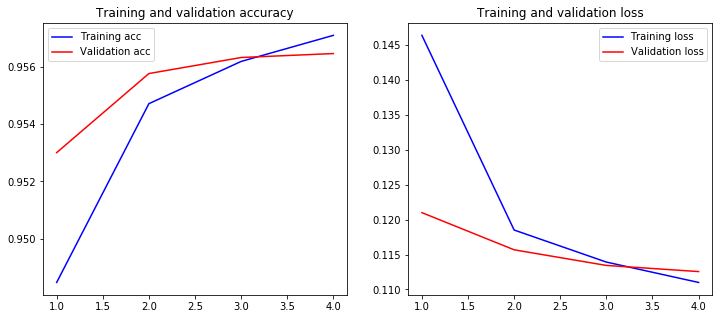

In [0]:
predicted = model.predict(np.array(X_dev_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
report(y_dev, cls_pred)
plot_roc(y_dev, predicted)
plot_history(history)
store_matrix("Paragram RNN (dev)", y_dev, cls_pred)

predicted = model.predict(np.array(X_train_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
store_matrix("Paragram RNN (train)", y_train, cls_pred)
del model, paragram_embeddings

In [0]:
fasttext_embeddings = load_fasttext(tokenizer.word_index) 
model = Sequential()
optimizer = Adam(lr=1e-3)
model.add(Embedding(weights=[fasttext_embeddings], trainable=False, input_dim=num_words, output_dim=embedding_size, input_length=max_tokens))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, dropout=0.5, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           2400000   
_________________________________________________________________
gru_12 (GRU)                 (None, 30, 32)            31968     
_________________________________________________________________
gru_13 (GRU)                 (None, 30, 16)            2352      
_________________________________________________________________
gru_14 (GRU)                 (None, 30, 8)             600       
_________________________________________________________________
gru_15 (GRU)                 (None, 4)                 156       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 2,435,081
Trainable params: 35,081
Non-trainable params: 2,400,000
_______________________________________

In [0]:
history = model.fit(np.array(X_train_token), y_train, validation_data=(np.array(X_dev_token),y_dev), epochs=4, batch_size=500)


Train on 1044892 samples, validate on 130612 samples
Epoch 1/4
1044892/1044892 [==============================] - 524s 501us/sample - loss: 0.1547 - auc_6: 0.8938 - acc: 0.9476 - val_loss: 0.1226 - val_auc_6: 0.9386 - val_acc: 0.9533
Epoch 2/4
1044892/1044892 [==============================] - 521s 498us/sample - loss: 0.1203 - auc_6: 0.9421 - acc: 0.9538 - val_loss: 0.1165 - val_auc_6: 0.9475 - val_acc: 0.9552
Epoch 3/4
1044892/1044892 [==============================] - 524s 501us/sample - loss: 0.1154 - auc_6: 0.9477 - acc: 0.9556 - val_loss: 0.1144 - val_auc_6: 0.9507 - val_acc: 0.9559
Epoch 4/4
1044892/1044892 [==============================] - 526s 504us/sample - loss: 0.1122 - auc_6: 0.9508 - acc: 0.9568 - val_loss: 0.1120 - val_auc_6: 0.9515 - val_acc: 0.9562


              precision    recall  f1-score   support

     Sincere       0.97      0.98      0.98    122531
   Insincere       0.68      0.55      0.61      8081

    accuracy                           0.96    130612
   macro avg       0.83      0.77      0.79    130612
weighted avg       0.95      0.96      0.95    130612



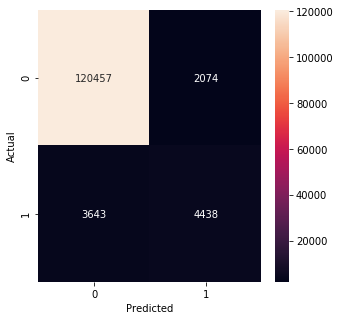

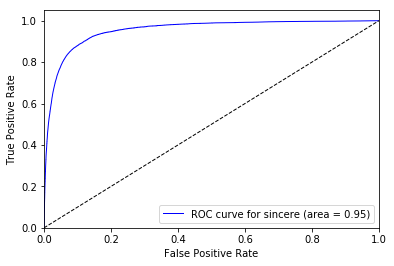

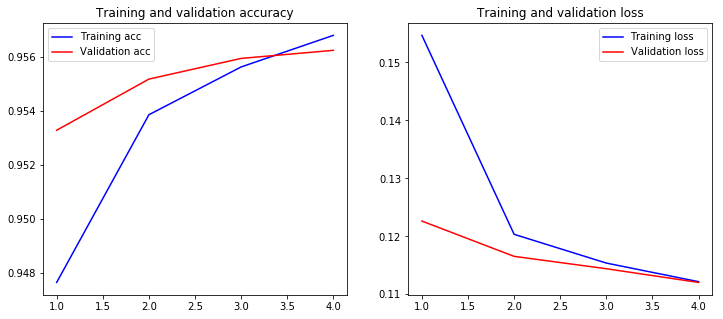

In [0]:
predicted = model.predict(np.array(X_dev_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
report(y_dev, cls_pred)
plot_roc(y_dev, predicted)
plot_history(history)
store_matrix("Fasttext RNN (dev)", y_dev, cls_pred)

predicted = model.predict(np.array(X_train_token))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])
store_matrix("Fasttext RNN (train)", y_train, cls_pred)
del model, fasttext_embeddings

#9. Language Model (Flair)


All the Language Models(LM) below have been made available in 2018. Most of LMs were trained in the unsupervised and for multi-tasking neural network. Flair is the first in this sequence.  

As the LMs are pre-trained, the input formats need to follow the specification. Also, the weights of the model can be fine-tuning for the project. 


In [0]:
# separated library installation as the new lib changed tensoflow's version 
# that interfered with tokenizer used in earlier steps
!pip install flair
!pip install tensorflow-hub
!pip install fastai

import tensorflow_hub as hub

from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data import Sentence
from pathlib import Path

from fastai.text import *


In [0]:
X = X_train_s.to_list() + X_test_s.to_list() + X_dev_s.to_list()
y = y_train_s.to_list() + y_test_s.to_list() + y_dev_s.to_list()


In [0]:
data = pd.DataFrame(list(zip(y, X)), columns =['label','text'])
data['label'] = '__label__' + data['label'].map({1: 'Insincere', 0: 'Sincere'})

data.iloc[0:int(len(data)*0.8)].to_csv(path+'flair/trainflair.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv(path+'flair/testflair.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv(path+'flair/devflair.csv', sep='\t', index = False, header = False);


In [0]:
corpus = NLPTaskDataFetcher.load_classification_corpus(Path(path+'flair/'),\
                                                       test_file='testflair.csv',\
                                                       dev_file='devflair.csv',\
                                                       train_file='trainflair.csv')

word_embeddings = [WordEmbeddings('glove'),\
                   FlairEmbeddings('news-forward-fast'),\
                   FlairEmbeddings('news-backward-fast')]

document_embeddings = DocumentLSTMEmbeddings(word_embeddings,
                                             hidden_size=512,\
                                             reproject_words=True,\
                                             reproject_words_dimension=256)

classifier = TextClassifier(document_embeddings,\
                            label_dictionary=corpus.make_label_dictionary(),\
                            multi_label=False)

trainer = ModelTrainer(classifier, corpus)

trainer.train(path+'flair/', max_epochs=20)

2019-08-21 01:34:41,528 Reading data from /content/gdrive/My Drive/data/flair
2019-08-21 01:34:41,530 Train: /content/gdrive/My Drive/data/flair/trainflair.csv
2019-08-21 01:34:41,532 Dev: /content/gdrive/My Drive/data/flair/devflair.csv
2019-08-21 01:34:41,534 Test: /content/gdrive/My Drive/data/flair/testflair.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) load_classification_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/flair/data_fetcher.py:447: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/usr/local/lib/python3.6/dist-packages/flair/data_fetcher.py:454: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/usr/local/lib/python3.6/dist-packages/flair/data_fetcher.py:463: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets

2019-08-21 01:35:36,734 {'Insincere', 'Sincere'}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  


2019-08-21 01:35:36,822 ----------------------------------------------------------------------------------------------------
2019-08-21 01:35:36,824 Evaluation method: MICRO_F1_SCORE
2019-08-21 01:35:37,416 ----------------------------------------------------------------------------------------------------
2019-08-21 01:35:38,797 epoch 1 - iter 0/4250 - loss 0.69242471
2019-08-21 01:37:48,510 epoch 1 - iter 425/4250 - loss 0.51124501
2019-08-21 01:40:07,824 epoch 1 - iter 850/4250 - loss 0.46929832
2019-08-21 01:42:13,730 epoch 1 - iter 1275/4250 - loss 0.44757036
2019-08-21 01:44:18,328 epoch 1 - iter 1700/4250 - loss 0.43244092
2019-08-21 01:46:34,227 epoch 1 - iter 2125/4250 - loss 0.42014258
2019-08-21 01:48:39,923 epoch 1 - iter 2550/4250 - loss 0.40883096
2019-08-21 01:50:57,951 epoch 1 - iter 2975/4250 - loss 0.40119206
2019-08-21 01:53:05,503 epoch 1 - iter 3400/4250 - loss 0.39464704
2019-08-21 01:55:11,420 epoch 1 - iter 3825/4250 - loss 0.38991738
2019-08-21 01:57:28,835 ---

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


2019-08-21 10:51:28,278 0.9035	0.9035	0.9035
2019-08-21 10:51:28,281 
MICRO_AVG: acc 0.824 - f1-score 0.9035
MACRO_AVG: acc 0.8236 - f1-score 0.9032
Insincere  tp: 7221 - fp: 861 - fn: 779 - tn: 8139 - precision: 0.8935 - recall: 0.9026 - accuracy: 0.8149 - f1-score: 0.8980
Sincere    tp: 8139 - fp: 779 - fn: 861 - tn: 7221 - precision: 0.9126 - recall: 0.9043 - accuracy: 0.8323 - f1-score: 0.9084
2019-08-21 10:51:28,283 ----------------------------------------------------------------------------------------------------


{'dev_loss_history': [tensor(0.3230, device='cuda:0'),
  tensor(0.3155, device='cuda:0'),
  tensor(0.3233, device='cuda:0'),
  tensor(0.3015, device='cuda:0'),
  tensor(0.3009, device='cuda:0'),
  tensor(0.2882, device='cuda:0'),
  tensor(0.2824, device='cuda:0'),
  tensor(0.2806, device='cuda:0'),
  tensor(0.2748, device='cuda:0'),
  tensor(0.2847, device='cuda:0'),
  tensor(0.2741, device='cuda:0'),
  tensor(0.2719, device='cuda:0'),
  tensor(0.2789, device='cuda:0'),
  tensor(0.2643, device='cuda:0'),
  tensor(0.2765, device='cuda:0'),
  tensor(0.2794, device='cuda:0'),
  tensor(0.2670, device='cuda:0'),
  tensor(0.2646, device='cuda:0'),
  tensor(0.2722, device='cuda:0'),
  tensor(0.2643, device='cuda:0')],
 'dev_score_history': [0.8675,
  0.8686,
  0.8673,
  0.8798,
  0.8782,
  0.8845,
  0.8869,
  0.8897,
  0.8901,
  0.8914,
  0.8925,
  0.8915,
  0.8881,
  0.8967,
  0.8887,
  0.8901,
  0.8971,
  0.8942,
  0.8966,
  0.8963],
 'test_score': 0.9035,
 'train_loss_history': [0.38467272

In [0]:
classifier = TextClassifier.load(path+'flair/best-model.pt')

# convert X_dev, the regular accuracy report set, to sentence object and perform prediction
sentences =[]
for s in X_dev.to_list():
  sentences.append(Sentence(s))
classifier.predict(sentences)

# convert prediction result to the format compile with the defined function

cls_pred, prob, prob_adj = [], [], []
for s in sentences:
  if s.labels[0].value == 'Sincere':
    cls_pred.append(0)
  else:
    cls_pred.append(1)
  prob.append(s.labels[0].score)

for i in range(0, len(prob)):
  if cls_pred[i] == 0:
    prob_adj.append(1-prob[i])
  else:
    prob_adj.append(prob[i])


2019-08-21 13:47:23,255 loading file /content/gdrive/My Drive/data/flair/best-model.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


              precision    recall  f1-score   support

     Sincere       0.99      0.90      0.94    122531
   Insincere       0.36      0.91      0.52      8081

    accuracy                           0.90    130612
   macro avg       0.68      0.90      0.73    130612
weighted avg       0.95      0.90      0.92    130612



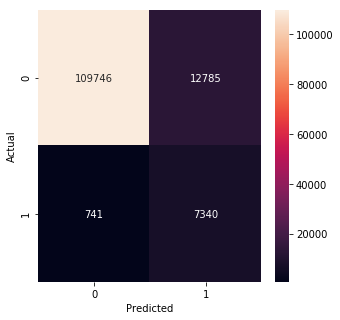

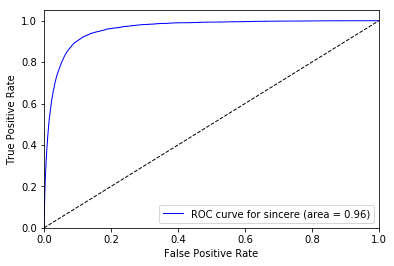

In [0]:
report(y_dev, cls_pred)
plot_roc(y_dev.values, np.asarray(prob_adj))
store_matrix("Flair (dev)", y_dev, cls_pred)
del classifier, trainer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
EPOCH             20 non-null int64
TIMESTAMP         20 non-null object
BAD_EPOCHS        20 non-null int64
LEARNING_RATE     20 non-null float64
TRAIN_LOSS        20 non-null float64
DEV_LOSS          20 non-null float64
DEV_PRECISION     20 non-null float64
DEV_RECALL        20 non-null float64
DEV_F1            20 non-null float64
TEST_LOSS         20 non-null float64
TEST_PRECISION    20 non-null float64
TEST_RECALL       20 non-null float64
TEST_F1           20 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 2.1+ KB
None



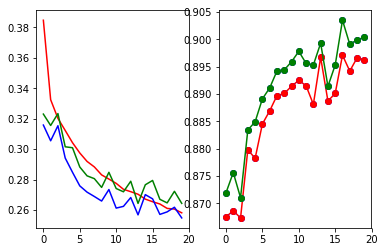

In [0]:
log = pd.read_csv(path+'flair/loss.tsv', sep='\t')
print(log.info())
print()

plt.figure(1)
plt.subplot(121)
plt.plot(log['EPOCH'], log['TRAIN_LOSS'], 'r', log['EPOCH'], log['DEV_LOSS'], 'g',\
         log['EPOCH'], log['TEST_LOSS'], 'b')

plt.subplot(122)
plt.plot(log['EPOCH'], log['DEV_PRECISION'] ,'r', log['EPOCH'], log['DEV_RECALL'] ,'bo',\
         log['EPOCH'], log['DEV_F1'], 'ro', log['EPOCH'], log['TEST_PRECISION'], 'g',\
         log['EPOCH'], log['TEST_RECALL'], 'bo',log['EPOCH'], log['TEST_F1'], 'go')
plt.show()

#10. Language Model (Universal Sentence Encoder)

Universal Sentence Encoder demonstrated here took two pre-trained models and set the trainable flag to False and True that makes four combinations.


In [0]:
TOTAL_STEPS = 4000
STEP_SIZE = 500

my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 2, # Retain the 2 most recent checkpoints.
)

# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_train_s.values}, y_train_s.values, 
    batch_size=256, num_epochs=None, shuffle=True)
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_train_s.values}, y_train_s.values, shuffle=False)
# Prediction on the whole validation set.
predict_val_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_dev_s.values},  y_dev_s.values, shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_dev.values}, y_dev.values, shuffle=False)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec=hub_module, trainable=train_module)
  
    print()
    print('Training with', hub_module)
    print('Trainable is:', train_module)
  
    dnn = tf.estimator.DNNClassifier(
        hidden_units=[512, 128],
        feature_columns=[embedding_feature],
        n_classes=2,
        activation_fn=tf.nn.relu,
        dropout=0.1,
        optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
        model_dir=path,
        config=my_checkpointing_config)

    for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
        print('Training for step =', step)
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))
        print('\n')

    predictions_train = get_predictions(estimator=dnn, input_fn=predict_train_input_fn)
    predictions_dev = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
    del dnn
    return predictions_train, predictions_dev
    

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]
  
tf.logging.set_verbosity(tf.logging.ERROR)


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: False
Training for step = 0
Eval Metrics (Train): {'accuracy': 0.887625, 'accuracy_baseline': 0.5294118, 'auc': 0.95139897, 'auc_precision_recall': 0.94077253, 'average_loss': 0.27968982, 'label/mean': 0.47058824, 'loss': 35.78346, 'precision': 0.8752947, 'prediction/mean': 0.47128934, 'recall': 0.8876719, 'global_step': 5000}
Eval Metrics (Validation): {'accuracy': 0.8775882, 'accuracy_baseline': 0.5294118, 'auc': 0.94400495, 'auc_precision_recall': 0.92948616, 'average_loss': 0.3000814, 'label/mean': 0.47058824, 'loss': 38.35627, 'precision': 0.8629952, 'prediction/mean': 0.4723745, 'recall': 0.8795, 'global_step': 5000}


Training for step = 500
Eval Metrics (Train): {'accuracy': 0.88836765, 'accuracy_baseline': 0.5294118, 'auc': 0.95209104, 'auc_precision_recall': 0.94154954, 'average_loss': 0.27894932, 'label/mean': 0.47058824, 'loss': 35.68872, 'precision': 0.8661936, 'prediction/mean': 0.4839746, 'recall': 0.

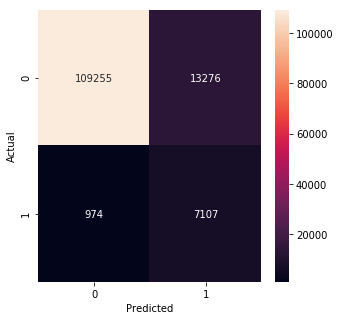

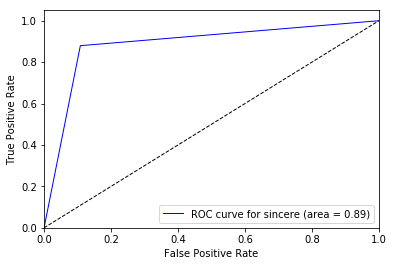

In [0]:
predictions_train, predictions_dev = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", path=path+'storage/models/nnlm-en-dim128_f/')


report(y_dev.values, predictions_dev)
plot_roc(y_dev.values, predictions_dev)
store_matrix("nnlm-en-dim128 (dev)", y_dev.values, predictions_dev)
store_matrix("nnlm-en-dim128 (train)", y_train_s.values, predictions_train)


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: True
Training for step = 0
Eval Metrics (Train): {'accuracy': 0.90575, 'accuracy_baseline': 0.5294118, 'auc': 0.96148914, 'auc_precision_recall': 0.9505174, 'average_loss': 0.24808967, 'label/mean': 0.47058824, 'loss': 31.740541, 'precision': 0.8936835, 'prediction/mean': 0.46821576, 'recall': 0.9077031, 'global_step': 500}
Eval Metrics (Validation): {'accuracy': 0.88817644, 'accuracy_baseline': 0.5294118, 'auc': 0.9508095, 'auc_precision_recall': 0.9365659, 'average_loss': 0.28010735, 'label/mean': 0.47058824, 'loss': 35.803192, 'precision': 0.8763421, 'prediction/mean': 0.46863368, 'recall': 0.887625, 'global_step': 500}


Training for step = 500
Eval Metrics (Train): {'accuracy': 0.919, 'accuracy_baseline': 0.5294118, 'auc': 0.96922135, 'auc_precision_recall': 0.95935535, 'average_loss': 0.2195183, 'label/mean': 0.47058824, 'loss': 28.085127, 'precision': 0.9104868, 'prediction/mean': 0.46126607, 'recall': 0.9181

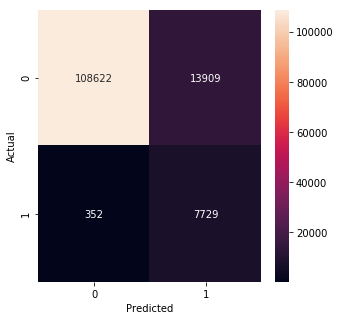

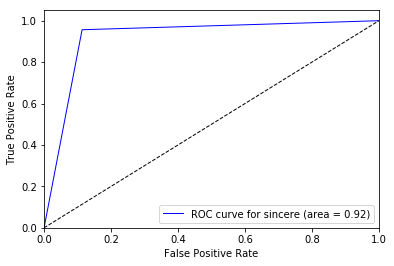

In [0]:
predictions_train, predictions_dev = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", train_module=True, path=path+'storage/models/nnlm-en-dim128_t/')

report(y_dev.values, predictions_dev)
plot_roc(y_dev.values, predictions_dev)
store_matrix("nnlm-en-dim128-with-training (dev)", y_dev.values, predictions_dev)
store_matrix("nnlm-en-dim128-with-training (train)", y_train_s.values, predictions_train)


Training with https://tfhub.dev/google/universal-sentence-encoder/2
Trainable is: False
Training for step = 0
Eval Metrics (Train): {'accuracy': 0.9010735, 'accuracy_baseline': 0.5294118, 'auc': 0.9584353, 'auc_precision_recall': 0.94753134, 'average_loss': 0.25662166, 'label/mean': 0.47058824, 'loss': 32.832123, 'precision': 0.8789396, 'prediction/mean': 0.4808475, 'recall': 0.9159375, 'global_step': 500}
Eval Metrics (Validation): {'accuracy': 0.8972353, 'accuracy_baseline': 0.5294118, 'auc': 0.9566559, 'auc_precision_recall': 0.94448525, 'average_loss': 0.26217982, 'label/mean': 0.47058824, 'loss': 33.511707, 'precision': 0.8710098, 'prediction/mean': 0.48271966, 'recall': 0.9175, 'global_step': 500}


Training for step = 500
Eval Metrics (Train): {'accuracy': 0.90617645, 'accuracy_baseline': 0.5294118, 'auc': 0.96222997, 'auc_precision_recall': 0.9523869, 'average_loss': 0.24406156, 'label/mean': 0.47058824, 'loss': 31.225185, 'precision': 0.8919109, 'prediction/mean': 0.47042626,

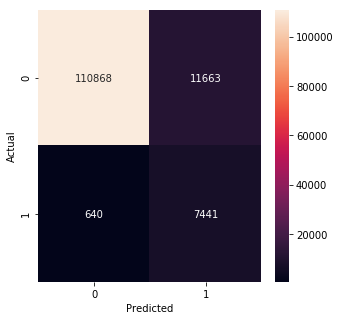

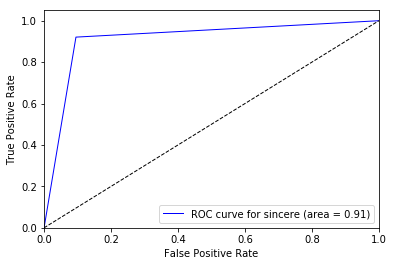

In [0]:
predictions_train, predictions_dev = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", path=path+'storage/models/use-512_f/')

report(y_dev.values, predictions_dev)
plot_roc(y_dev.values, predictions_dev)
store_matrix("use-512 (dev)", y_dev.values, predictions_dev)
store_matrix("use-512 (train)", y_train_s.values, predictions_train)


Training with https://tfhub.dev/google/universal-sentence-encoder/2
Trainable is: True
Training for step = 0
Eval Metrics (Train): {'accuracy': 0.9515441, 'accuracy_baseline': 0.5294118, 'auc': 0.9842875, 'auc_precision_recall': 0.9784622, 'average_loss': 0.1532107, 'label/mean': 0.47058824, 'loss': 19.601744, 'precision': 0.93675065, 'prediction/mean': 0.472505, 'recall': 0.9619844, 'global_step': 500}
Eval Metrics (Validation): {'accuracy': 0.9090588, 'accuracy_baseline': 0.5294118, 'auc': 0.96440685, 'auc_precision_recall': 0.9538017, 'average_loss': 0.2354746, 'label/mean': 0.47058824, 'loss': 30.098257, 'precision': 0.8921974, 'prediction/mean': 0.4724879, 'recall': 0.917625, 'global_step': 500}


Training for step = 500
Eval Metrics (Train): {'accuracy': 0.9834853, 'accuracy_baseline': 0.5294118, 'auc': 0.99590105, 'auc_precision_recall': 0.99409294, 'average_loss': 0.06396463, 'label/mean': 0.47058824, 'loss': 8.183621, 'precision': 0.9808004, 'prediction/mean': 0.46222413, 're

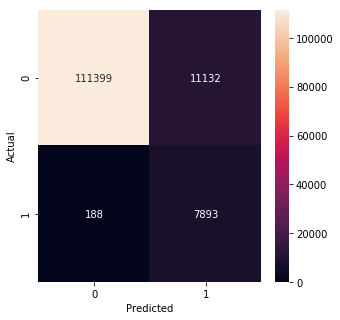

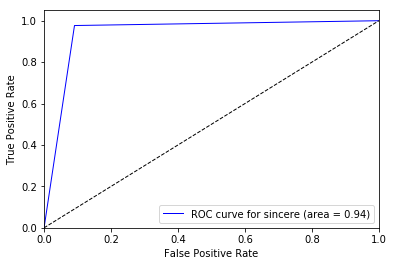

In [0]:
predictions_test, predictions_dev = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", train_module=True, path=path+'storage/models/use-512_t/')


report(y_dev.values, predictions_dev)
plot_roc(y_dev.values, predictions_dev)
store_matrix("use-512-with-training (dev)", y_dev.values, predictions_dev)
store_matrix("use-512-with-training (train)", y_train_s.values, predictions_train)

#11. Language Model (FastAI/ULMFiT)

ULMFiT is the last model in this LM sequence. 

In [0]:
from fastai.text import *

In [0]:
#fast ai use minimum text preprocessing, should reflect back to raw data?!
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':X_train_s.values, 'labels':y_train_s.values}, columns=col_names)
df_val = pd.DataFrame({'text':X_dev_s.values, 'labels':y_dev_s.values}, columns=col_names)

# Language model data
data_lm = TextLMDataBunch.from_df(path+'fastai', train_df=df_trn, valid_df=df_val)
data_lm.save('tmp_lm') #data_lm = load_data(path+'fastai', 'tmp_lm')
#data_lm.vocab.itos[:20]

In [0]:
data_lm_f = load_data(path+'fastai', 'tmp_lm') #forward
#data_lm_f.show_batch()

# Language model, train and save
learner_f = language_model_learner(data_lm_f, AWD_LSTM, drop_mult=0.5)
learner_f = learner_f.to_fp16(clip=0.1)
learner_f.lr_find()
learner_f.recorder.plot()

learner_f.fit_one_cycle(1, 1e-2)
learner_f.recorder.plot_lr(show_moms=True)
learner_f.unfreeze()
learner_f.fit_one_cycle(1, 1e-3)
learner_f.save_encoder('f_enc')

# Classifier model data
data_clas_f = TextClasDataBunch.from_df(path+'fastai', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)
classifier_f = text_classifier_learner(data_clas_f, AWD_LSTM, drop_mult=0.5)
classifier_f.load_encoder('f_enc')
classifier_f.lr_find()
classifier_f.recorder.plot()
classifier_f.fit_one_cycle(1, 1e-2)
classifier_f.recorder.plot_losses()
classifier_f.freeze_to(-2)
classifier_f.fit_one_cycle(1, slice(5e-3/2., 5e-3))
classifier_f.recorder.plot_losses()
classifier_f.unfreeze()
classifier_f.fit_one_cycle(1, slice(2e-3/100, 2e-3))
classifier_f.save('fwd_clas')
dump(classifier_f, path+'classifier_f.sav')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [0]:
data_lm_b = load_data(path+'fastai', 'tmp_lm',backwards=True) #backward
#data_lm_b.show_batch()

learner_b = language_model_learner(data_lm_b, AWD_LSTM, drop_mult=0.5)
learner_b = learner_b.to_fp16(clip=0.1)
learner_b.lr_find()
learner_b.recorder.plot()

#learner.fit_one_cycle(1, 2e-2, moms=(0.8,0.7), wd=0.1)
learner_b.fit_one_cycle(1, 1e-2)
learner_b.recorder.plot_lr(show_moms=True)
learner_b.unfreeze()
learner_b.fit_one_cycle(1, 1e-3)
learner_b.save_encoder('b_enc')

# Classifier model data
data_clas_b = TextClasDataBunch.from_df(path+'fastai', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32, backwards=True)
classifier_b = text_classifier_learner(data_clas_b, AWD_LSTM, drop_mult=0.5) #pretrained=False
classifier_b.load_encoder('b_enc')
classifier_b.lr_find()
classifier_b.recorder.plot()
classifier_b.fit_one_cycle(1, 1e-2) 
classifier_b.recorder.plot_losses()
classifier_b.freeze_to(-2)
classifier_b.fit_one_cycle(1, slice(5e-3/2., 5e-3))
classifier_b.recorder.plot_losses()
classifier_b.unfreeze()
classifier_b.fit_one_cycle(1, slice(2e-3/100, 2e-3))
classifier_b.save('bwd_clas')
dump(classifier_b, path+'classifier_b.sav')

col_0     0     1
row_0            
0      8036   662
1       964  7338
              precision    recall  f1-score   support

     Sincere       0.92      0.89      0.91      9000
   Insincere       0.88      0.92      0.90      8000

    accuracy                           0.90     17000
   macro avg       0.90      0.91      0.90     17000
weighted avg       0.91      0.90      0.90     17000



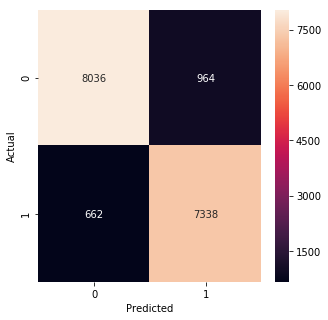

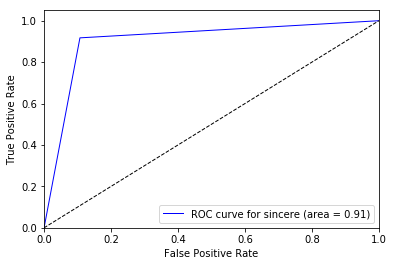

0.9050694444444445

In [0]:
# this get prediction for validation set 
pred_fwd,lbl_fwd = classifier_f.get_preds() 
pred_bwd,lbl_bwd = classifier_b.get_preds()
final_pred = (pred_fwd+pred_bwd)/2
pred = np.argmax(final_pred, axis = 1)
report(lbl_bwd, pred)
plot_roc(lbl_bwd, pred)

In [0]:
# this get prediction for validation set 
classifier_b = load(path +'classifier_b.sav')
classifier_f = load(path +'classifier_f.sav')
pred_fwd,lbl_fwd = classifier_f.get_preds() 
pred_bwd,lbl_bwd = classifier_b.get_preds()
final_pred = (pred_fwd+pred_bwd)/2
pred = np.argmax(final_pred, axis = 1)
report(lbl_bwd, pred)
plot_roc(lbl_bwd, pred)

In [0]:
pred_f = classifier_f.predict(X_dev.values)
dump(pred_f, path+'pred_f.sav')

In [0]:
pred_b =classifier_b.predict(X_dev.values)
dump(pred_b, path+'pred_b.sav')

In [0]:
#pred_f =classifier_f.predict(X_dev.values)
#pred_b =classifier_b.predict(X_dev.values)
final_pred = (pred_f+pred_b)/2
pred = np.argmax(final_pred, axis = 1)
#pd.crosstab(pred, lbl_bwd)
report(y_dev, pred)
plot_roc(y_dev, pred)
store_matrix("ULMFiT (dev)", y_dev, pred)

#12. Matrix Comparison 

This section reports the summary for the matrix from the above models.  Just a reminder that the models are not fine-tuned to reach the best performance and I do not make an argument on which is the best model for this question. However, if the target score if f1-score, the RNN and LM is the clear winner as they are more complicated model such that able to hold more information within the structure. 

In [0]:
matrix_s = load(path +'matrix_project.sav')
matrix_dev, matrix_train = {},{}
for key in matrix_s:
    if key.find('dev') != -1:
      matrix_dev[key] = matrix_s[key]
    else:
      matrix_train[key] = matrix_s[key]

dev_df = pd.DataFrame.from_dict(matrix_dev, orient="index")
train_df = pd.DataFrame.from_dict(matrix_train, orient="index")

In [0]:
train_df

,Accuracy,AUC,Precision (macro),Recall (macro),f1 (macro),misclassifications
Doc2Vec (PV-DBOW) Logistic Regression (train),0.809654,0.799570,0.599402,0.799570,0.613789,0.190346
Doc2Vec (PV-DM) Logistic Regression (train),0.813252,0.773493,0.594061,0.773493,0.608532,0.186748
Fasttext RNN (train),0.957946,0.774430,0.834714,0.774430,0.801064,0.042054
Glove RNN (train),0.958675,0.756353,0.850115,0.756353,0.794791,0.041325
Paragram RNN (train),0.958757,0.777001,0.839423,0.777001,0.804500,0.041243
Pre-Trained Glove Logistic Regression (train),0.870427,0.876650,0.650033,0.876650,0.692054,0.129573
Pre-Trained GoogleNew Logistic Regression (train),0.864540,0.870153,0.644275,0.870153,0.683761,0.135460
Pre-Trained Paragram Logistic Regression (train),0.859826,0.865141,0.639915,0.865141,0.677358,0.140174
Pre-Trained Wiki Logistic Regression (train),0.866119,0.873603,0.646174,0.873603,0.686464,0.133881
RNN (train),0.968724,0.830810,0.884366,0.830810,0.855253,0.031276


In [0]:
dev_df  #dev_df.sort('f1 (macro)', ascending=False)

,Accuracy,AUC,Precision (macro),Recall (macro),f1 (macro),misclassifications
Doc2Vec (PV-DBOW) Logistic Regression (dev),0.812490,0.798115,0.600065,0.798115,0.615512,0.187510
Doc2Vec (PV-DM) Logistic Regression (dev),0.812184,0.775182,0.594116,0.775182,0.608272,0.187816
Doc2Vec DM=0 Logistic Regression (dev),0.813225,0.797698,0.600231,0.797698,0.615948,0.186775
Doc2Vec DM=1 Logistic Regression (dev),0.810178,0.775153,0.593397,0.775153,0.606784,0.189822
Fasttext RNN (dev),0.956229,0.766132,0.826078,0.766132,0.792528,0.043771
Glove RNN (dev),0.956972,0.748554,0.840367,0.748554,0.786102,0.043028
Paragram RNN (dev),0.956459,0.767063,0.827314,0.767063,0.793590,0.043541
Pre-Trained Glove Logistic Regression (dev),0.871620,0.875633,0.650724,0.875633,0.693080,0.128380
Pre-Trained GoogleNew Logistic Regression (dev),0.866000,0.871886,0.645705,0.871886,0.685834,0.134000
Pre-Trained Paragram Logistic Regression (dev),0.860832,0.864624,0.640470,0.864624,0.678245,0.139168
